<h1>4. Zeitreihen vorhersagen (Statistik II): ARIMA-Modelle</h1>
<h4>Session 4 (Dienstag)</h4>
<br>
4.1 Autoregressive- (AR) und Moving Average (MA) Modelle<br>
4.2 Mit ARMA und ARIMA-Modellen vorhersagen<br>
4.3 Mit SARIMA-Modellen Saisonalität berücksichtigen<br>

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [31]:
em = pd.read_csv("em_HH8_2012_05.csv", index_col=0)
em['Zeit'] = pd.to_datetime(em['Zeit'])
em.set_index('Zeit', inplace=True)
em.index.freq = 'H'
em.head()

,Strom
Zeit,
2012-05-01 00:00:00,834.0
2012-05-01 01:00:00,824.0
2012-05-01 02:00:00,681.0
2012-05-01 03:00:00,530.0
2012-05-01 04:00:00,672.0


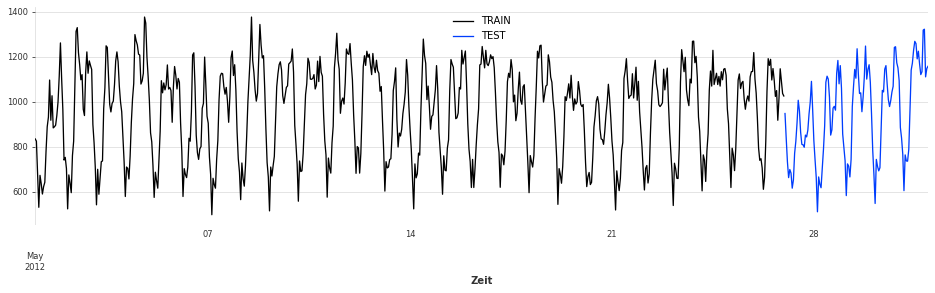

In [32]:
train_em = em[:624]
test_em = em[624:]
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4));

<h3> Ein-Schrittvorhersage Naiv </h3>

In [33]:
train_em.tail()

,Strom
Zeit,
2012-05-26 19:00:00,1016.0
2012-05-26 20:00:00,1146.0
2012-05-26 21:00:00,1092.0
2012-05-26 22:00:00,1036.0
2012-05-26 23:00:00,1025.0


In [34]:
naiv = pd.DataFrame()
naiv = naiv.reindex_like(test_em)
#naiv = naiv.assign('Strom'==last)
naiv['Strom'] = train_em.iloc[623]['Strom']
naiv.columns = ['Naive Vorhersage']
naiv.head()

,Naive Vorhersage
Zeit,
2012-05-27 00:00:00,1025.0
2012-05-27 01:00:00,1025.0
2012-05-27 02:00:00,1025.0
2012-05-27 03:00:00,1025.0
2012-05-27 04:00:00,1025.0


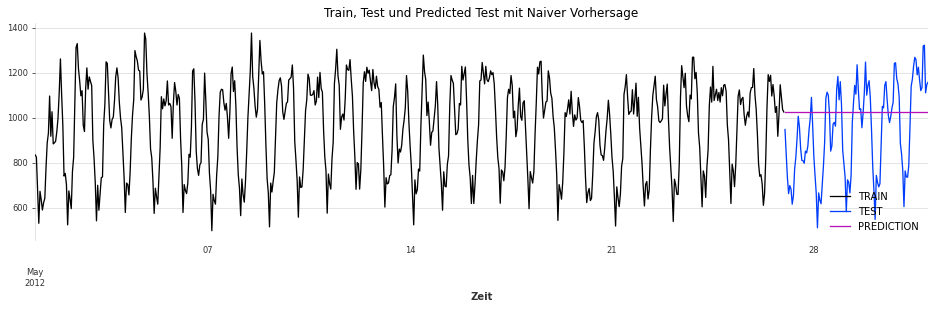

In [35]:
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
naiv['Naive Vorhersage'].plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit Naiver Vorhersage');

<h3> ARIMA-Modelle: Zuerst Voraussetzungen prüfen </h3>

Ist die Zeitreihe stationär?<br>
Dickey-Fuller-Test (Null-Hypothese nicht stationär)

In [36]:
testresults = adfuller(train_em)
print("Test statistic = {:.2f}".format(testresults[0]))
print("p-Value = {:.2f}".format(testresults[1]))
print("Number of lags = {:.2f}".format(testresults[2]))
print("Number of observations = {:.2f}".format(testresults[3]))
print("Critical value at 1% = {:.2f}".format(testresults[4]["1%"]))
print("Critical value at 5% = {:.2f}".format(testresults[4]["5%"]))
print("Critical value at 10% = {:.2f}".format(testresults[4]["10%"]))

Test statistic = -5.39
p-Value = 0.00
Number of lags = 19.00
Number of observations = 604.00
Critical value at 1% = -3.44
Critical value at 5% = -2.87
Critical value at 10% = -2.57


<h3> ARIMA-Modelle: Zuerst p,d,q, P,D,Q, s bestimmen </h3>

<h3>Geometrische Hinweise aus der ACF- und PACF-Funktion</h3>

Die ACF- und PACF-Kurven sollten zusammen betrachtet werden, um den Prozess zu definieren. Bei einem AR-Prozess erwarten wir, dass die ACF-Kurve allmählich abnimmt und gleichzeitig die PACF-Kurve nach p signifikanten Verzögerungen einen starken Abfall aufweist. Um einen MA-Prozess zu definieren, erwarten wir von den ACF- und PACF-Diagrammen das Gegenteil, d. h., die ACF sollte nach einer bestimmten Anzahl q von Lags einen starken Abfall aufweisen, während die PACF einen geometrischen oder allmählich abnehmenden Trend zeigen sollte. Zeigen dagegen sowohl die ACF- als auch die PACF-Kurven ein allmählich abnehmendes Muster, dann sollte der ARMA-Prozess für die Modellierung in Betracht gezogen werden.

Wir können die Ordnung p für das AR(p)-Modell auf der Grundlage signifikanter Spikes aus dem PACF-Diagramm auswählen. Alles, was außerhalb der blauen Begrenzung des PACF-Diagramms liegt, gibt Hinweise auf die Ordnung des AR-Modells.

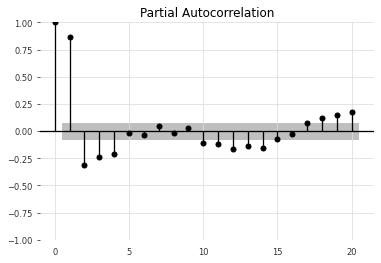

In [37]:
plot_pacf(train_em, lags=20, method='ywm');

In [38]:
for_mod = SARIMAX(train_em, 
              order=(1, 0, 0))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9943      0.005    220.238      0.000       0.985       1.003
sigma2      1.071e+04    715.485     14.968      0.000    9307.184    1.21e+04


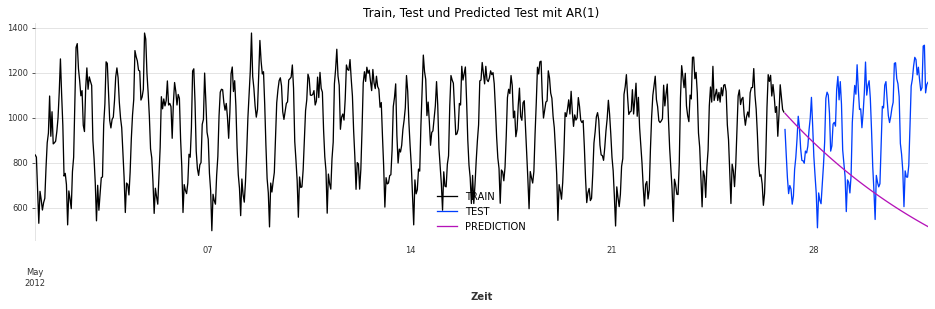

In [39]:
for_pred = for_results.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit AR(1)');

Im Gegensatz zum AR-Modell kann die Ordnung q für das Modell MA(q) aus dem ACF ausgewählt werden, wenn dieses Diagramm einen scharfen Cut-off nach dem Lag q aufweist.

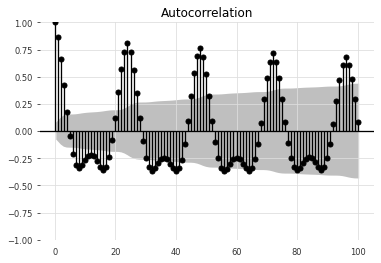

In [40]:
plot_acf(train_em, lags=100);

In [41]:
warnings.filterwarnings("ignore")
for_mod = SARIMAX(train_em, 
              order=(1, 0, 3))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9877      0.007    143.589      0.000       0.974       1.001
ma.L1          0.2112      0.042      5.080      0.000       0.130       0.293
ma.L2          0.1584      0.044      3.573      0.000       0.071       0.245
ma.L3          0.1681      0.044      3.785      0.000       0.081       0.255
sigma2      9891.8856    633.869     15.606      0.000    8649.526    1.11e+04


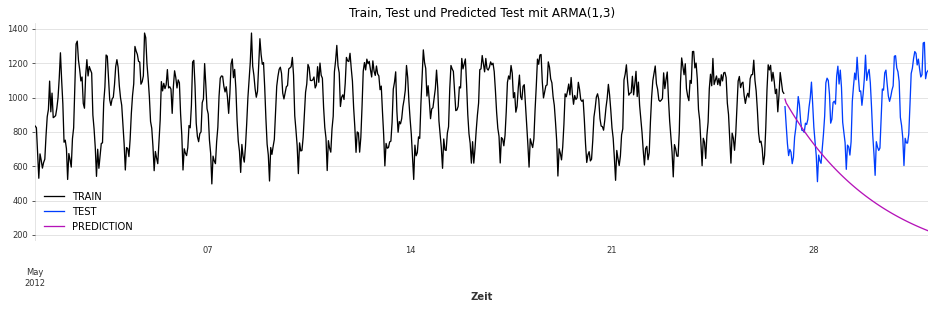

In [42]:
for_pred = for_results.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit ARMA(1,3)');

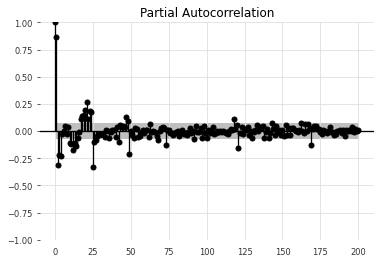

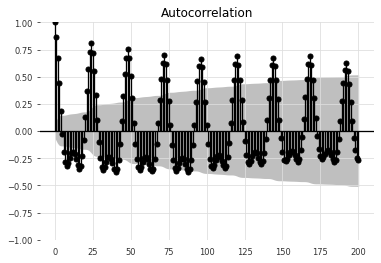

In [43]:
plot_pacf(em, lags=200, method='ywm');plot_acf(em, lags=200);

In [44]:
#warnings.filterwarnings("ignore")
for_mod = SARIMAX(train_em, 
              order=(1, 0, 3), 
              seasonal_order=(1, 0, 1, 24))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9812      0.009    103.464      0.000       0.963       1.000
ma.L1         -0.3067      0.041     -7.545      0.000      -0.386      -0.227
ma.L2         -0.2185      0.039     -5.549      0.000      -0.296      -0.141
ma.L3         -0.1343      0.040     -3.335      0.001      -0.213      -0.055
ar.S.L24       0.9988      0.001   1171.025      0.000       0.997       1.000
ma.S.L24      -0.8997      0.032    -28.044      0.000      -0.963      -0.837
sigma2      3576.9032    193.728     18.464      0.000    3197.204    3956.602


In [45]:
for_mod = SARIMAX(train_em, 
              order=(2, 0, 3), 
              seasonal_order=(1, 0, 1, 24))
for_results = for_mod.fit()
print(for_results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0042      0.001      3.694      0.000       0.002       0.006
ar.L2          0.9958      0.001    875.572      0.000       0.994       0.998
ma.L1          0.6258      0.011     58.972      0.000       0.605       0.647
ma.L2         -0.4963      0.003   -155.443      0.000      -0.503      -0.490
ma.L3         -0.1285      0.001   -167.625      0.000      -0.130      -0.127
ar.S.L24       0.9976      0.001    788.743      0.000       0.995       1.000
ma.S.L24      -0.9232      0.009   -100.984      0.000      -0.941      -0.905
sigma2      5059.7174     84.282     60.034      0.000    4894.529    5224.906


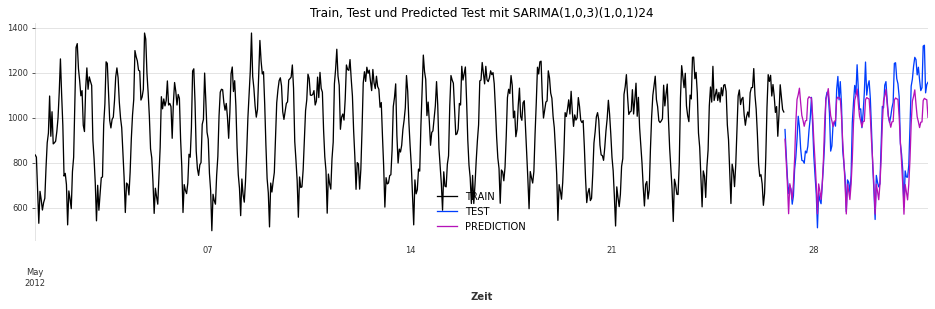

In [46]:
for_pred = for_results.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit SARIMA(1,0,3)(1,0,1)24');

Zur Validierung des Modells z.B. prüfen, ob die Residuen, also die geschätzten $\epsilon_t$, unkorreliert sind und sich wie weißes Rauschen verhalten.

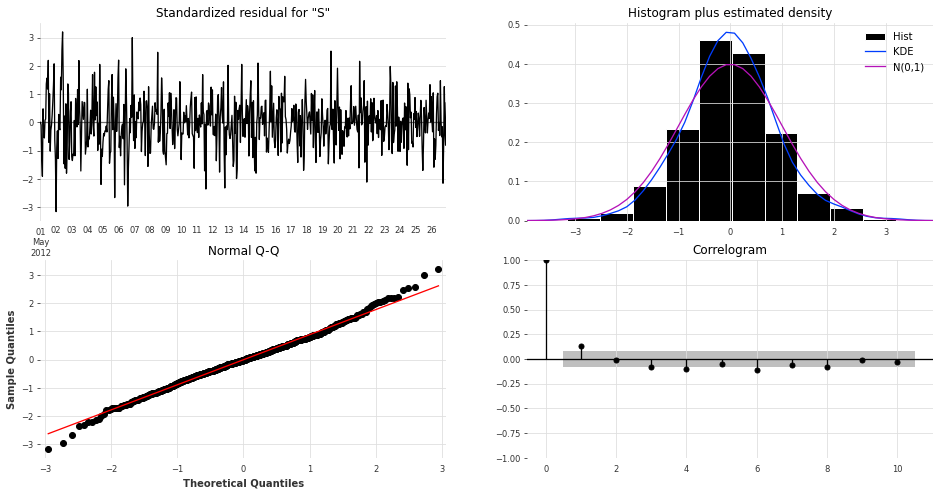

In [47]:
for_results.plot_diagnostics(figsize=(16, 8))
plt.show()

<h3>Wie gut ist mein Modell?</h3>

Erinnerung:<br>
Mean Absolute Error Holt-Winter = 87<br>
Mean Squared Error Holt-Winter = 11600

In [48]:
y_tru = test_em
y_SARIMA = for_pred.predicted_mean
errors = [['Mean Absolute Error', 87, mean_absolute_error(y_tru,y_SARIMA)], ['Mean Squared Error', 11600, mean_squared_error(y_tru,y_SARIMA)]] 
errors = pd.DataFrame(errors, columns = ['Art des Fehlers','Holt-Winters Vorhersage','SARIMA Vorhersage']) 
errors.set_index('Art des Fehlers', inplace=True) 
errors = round(errors, 2)
errors 

,Holt-Winters Vorhersage,SARIMA Vorhersage
Art des Fehlers,,
Mean Absolute Error,87,77.15
Mean Squared Error,11600,9885.07


<h3> Modellidentifikation: (p,d,q)(P,D,Q) bestimmen </h3>
Man kann die Parameter noch systematischer bestimmen - bzw. bestimmen lassen

In [20]:
# -> dauert evtl lange (ca. 1-2 Min)...
warnings.filterwarnings("ignore")
p = q = range(0, 3)
d = 0
pdq = list(itertools.product(p, [d], q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, [d], q))]
print(pdq)
print(seasonal_pdq)
df = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = SARIMAX(train_em,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        d = {
            'non-seasonal' : param,
            'seasonal' : param_seasonal,
            'AIC' : results.aic
        }
        df.append(d)
df = pd.DataFrame(df)
df['AIC'] = df['AIC'].astype(float)
df.to_csv('pdqPDQ.csv') 

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2)]
[(0, 0, 0, 24), (0, 0, 1, 24), (0, 0, 2, 24), (1, 0, 0, 24), (1, 0, 1, 24), (1, 0, 2, 24), (2, 0, 0, 24), (2, 0, 1, 24), (2, 0, 2, 24)]


KeyboardInterrupt: 

In [ ]:
pdq = pd.read_csv("pdqPDQ.csv")
pdq = pdq.drop(columns=['Unnamed: 0'])
print('Beispiele...')
print(pdq.head())
print('Minimum AIC bei')
print(pdq[ pdq['AIC'] == pdq['AIC'].min() ])

<div class="alert alert-info">
- Führe mit dem vorgeschlagenen Modell eine SARIMA-Vorhersage für unsere Testzeitspanne durch<br>
(- Plotte die Ergebnisse deiner Vorhersage in den obigen Plot dazu (so, dass du auch die SARIMA-Ergebnisse mit händisch bestimmten Parametern im selben Plot hast))<br>
(- Passe die Labels an, so dass klar wird welche Linie was ist)<br>
- Wie sieht es aus? Kann man einen Unterschied erkennen?<br>
- Bestimme zu deiner Analyse die Fehlermaße und füge sie in die obige Tabelle ein<br>
- Welche SARIMA-Analyse schneidet besser ab? Warum denkst du ist das so?
</div>

In [49]:
for_mod0 = SARIMAX(train_em, 
              order=(1, 1, 1), 
              seasonal_order=(1, 1, 1, 24))
for_results0 = for_mod0.fit()
print(for_results0.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5674      0.047     11.978      0.000       0.475       0.660
ma.L1         -0.9175      0.022    -41.042      0.000      -0.961      -0.874
ar.S.L24      -0.0850      0.045     -1.894      0.058      -0.173       0.003
ma.S.L24      -0.8790      0.034    -25.925      0.000      -0.945      -0.813
sigma2      3585.6322    190.013     18.870      0.000    3213.214    3958.050


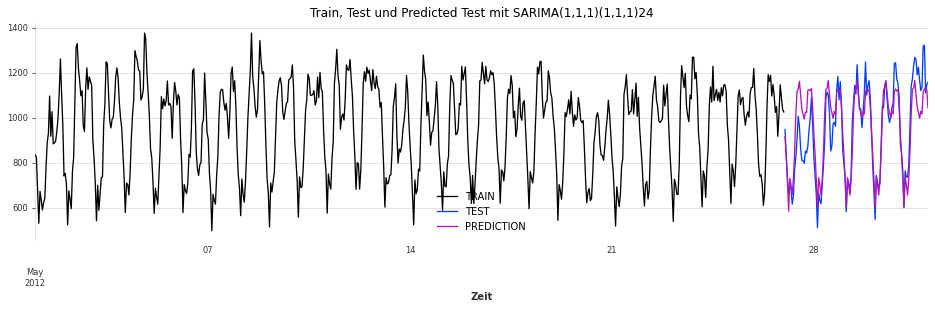

In [50]:
for_pred0 = for_results0.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred0.predicted_mean.plot(legend=True,label='PREDICTION')
plt.title('Train, Test und Predicted Test mit SARIMA(1,1,1)(1,1,1)24');

In [51]:
for_mod1 = SARIMAX(train_em, 
              order=(2, 0, 3), 
              seasonal_order=(1, 0, 1, 24))
for_results1 = for_mod1.fit()
print(for_results1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0042      0.001      3.694      0.000       0.002       0.006
ar.L2          0.9958      0.001    875.572      0.000       0.994       0.998
ma.L1          0.6258      0.011     58.972      0.000       0.605       0.647
ma.L2         -0.4963      0.003   -155.443      0.000      -0.503      -0.490
ma.L3         -0.1285      0.001   -167.625      0.000      -0.130      -0.127
ar.S.L24       0.9976      0.001    788.743      0.000       0.995       1.000
ma.S.L24      -0.9232      0.009   -100.984      0.000      -0.941      -0.905
sigma2      5059.7174     84.282     60.034      0.000    4894.529    5224.906


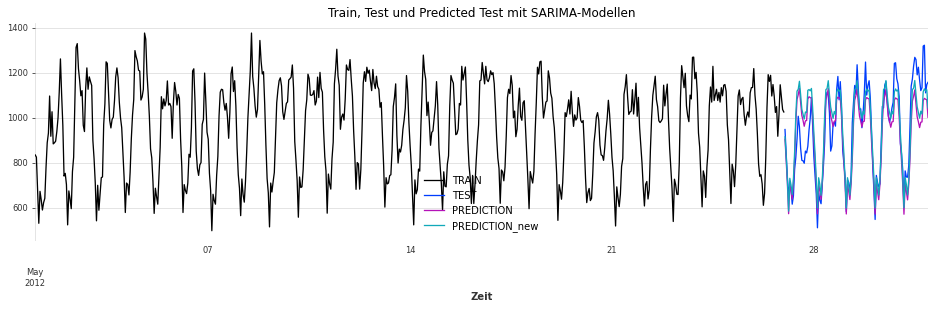

In [52]:
for_pred1 = for_results1.get_forecast(steps=120)
train_em['Strom'].plot(legend=True,label='TRAIN')
test_em['Strom'].plot(legend=True,label='TEST',figsize=(16,4))
for_pred1.predicted_mean.plot(legend=True,label='PREDICTION')
for_pred0.predicted_mean.plot(legend=True,label='PREDICTION_new')
plt.title('Train, Test und Predicted Test mit SARIMA-Modellen');

In [53]:
y_tru = test_em
y_SARIMA0 = for_pred0.predicted_mean
y_SARIMA1 = for_pred1.predicted_mean
errors = [['Mean Absolute Error', mean_absolute_error(y_tru,y_SARIMA1), mean_absolute_error(y_tru,y_SARIMA0)], ['Mean Squared Error', mean_squared_error(y_tru,y_SARIMA1), mean_squared_error(y_tru,y_SARIMA0)]] 
errors = pd.DataFrame(errors, columns = ['Art des Fehlers','Händische SARIMA Vorhersage','Automatische SARIMA Vorhersage']) 
errors.set_index('Art des Fehlers', inplace=True) 
errors = round(errors, 2)
errors 

,Händische SARIMA Vorhersage,Automatische SARIMA Vorhersage
Art des Fehlers,,
Mean Absolute Error,77.15,72.41
Mean Squared Error,9885.07,9183.88
